In [1]:
from utils import extract_scaling_metadata
from pathlib import Path
import czifile
from czifile import SegmentNotFoundError
import napari
import numpy as np
import skimage
from skimage import measure, exposure
from skimage.measure import regionprops_table
import pandas as pd
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import dask
# import gc

# Select a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device("RTX")

c:\Users\albertds\mambaforge\envs\microglia\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with RTX in their name. Using Intel(R) UHD Graphics 630 instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<Intel(R) UHD Graphics 630 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

In [2]:
directory_path = Path("./raw_data/")
images = []

# Iterate through the lsm files in the directory
for file_path in directory_path.glob("*.czi"):
    images.append(str(file_path))
    
images

['raw_data\\well 1.czi',
 'raw_data\\well 10.czi',
 'raw_data\\well 11.czi',
 'raw_data\\well 12.czi',
 'raw_data\\well 13.czi',
 'raw_data\\well 14.czi',
 'raw_data\\well 15.czi',
 'raw_data\\well 2.czi',
 'raw_data\\well 3.czi',
 'raw_data\\well 4.czi',
 'raw_data\\well 5.czi',
 'raw_data\\well 6.czi',
 'raw_data\\well 7.czi',
 'raw_data\\well 8.czi',
 'raw_data\\well 9.czi']

In [3]:
# Initialize an empty list to store dataframes
dataframes = []

for image in images:

    # Extract filename and well_id
    file_path = Path(image)
    filename = file_path.stem
    well_id = filename.split(" ")[1]

    # Read the image file and remove singleton dimensions
     
    img = czifile.imread(image)
    img = img.squeeze()
    print(img.shape)

(4, 29, 7720, 7711)
(4, 26, 7700, 7700)
(4, 29, 7700, 7700)
(4, 26, 7700, 7700)
(4, 28, 7700, 7700)
(4, 26, 7700, 7700)
(4, 29, 7700, 7700)
(4, 26, 7713, 7709)
(4, 26, 7698, 7710)
(4, 25, 7706, 7717)
(4, 29, 7700, 7700)
(4, 25, 7700, 7700)
(4, 26, 7700, 7700)
(4, 20, 7700, 7700)
(4, 35, 7700, 7700)


In [4]:
# Initialize an empty list to store dataframes
dataframes = []

for image in images:

    # Extract filename and well_id
    file_path = Path(image)
    filename = file_path.stem
    well_id = filename.split(" ")[1]

    # Read the image file and remove singleton dimensions
    try: 
        img = czifile.imread(image)
        img = img.squeeze()

        # Image size reduction to improve processing times (slicing, not lossless compression)
        slicing_factor = 4 # Use 2 or 4 for compression (None for lossless)

        # Extract the stack containing the nuclei (0), dna_damage (1) and microglia channel (2)
        ki67_stack = img[0, :, ::slicing_factor, ::slicing_factor]
        nuclei_stack = img[2, :, ::slicing_factor, ::slicing_factor]
        caspase_stack = img[3, :, ::slicing_factor, ::slicing_factor]

        # Perform maximum intensity projections
        ki67_mip = np.max(ki67_stack, axis = 0)
        nuclei_mip = np.max(nuclei_stack, axis = 0)
        caspase_mip = np.max(caspase_stack, axis = 0)

        # Free up memory by deleting the img variable
        del img
        # Call the garbage collector
        # gc.collect()
        
        
        input_image = nuclei_stack
        
        # Extract x,y,z scaling from .czi file metadata in order to make data isotropic
        scaling_x_um, scaling_y_um, scaling_z_um = extract_scaling_metadata(file_path)

        # Adjust so voxel size_x and size_y so they are equal to 1 to avoid compression upon rescaling (running 0.5 due to memory issues)
        multiplier = 0.5 / scaling_x_um

        scaling_x_um = scaling_x_um * multiplier
        scaling_y_um = scaling_y_um * multiplier
        scaling_z_um = scaling_z_um * multiplier

        resampled = cle.scale(input_image, factor_x=scaling_x_um, factor_y=scaling_y_um, factor_z=scaling_z_um, auto_size=True)
        background_subtracted = cle.top_hat_box(resampled, radius_x=5, radius_y=5, radius_z=5)
        del resampled
        segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=1, outline_sigma=1)
        del background_subtracted
        resampled_ki67 = cle.scale(ki67_stack, factor_x=scaling_x_um, factor_y=scaling_y_um, factor_z=scaling_z_um, auto_size=True)
        
        nuclei_labels_3d = cle.pull(segmented)
        resampled_ki67 = cle.pull(resampled_ki67)

        # Extract regionprops
        props = regionprops_table(label_image=nuclei_labels_3d, intensity_image=resampled_ki67, properties=["label", "intensity_mean", "intensity_max", "centroid", "area_filled"])

        # Construct a dataframe
        df = pd.DataFrame(props)
        
        # Add the well_id column with the filename
        df.insert(0, "well_id", well_id)
        
        # Append the dataframe to the list
        dataframes.append(df)
        
    except SegmentNotFoundError:
        print(f"Segment not found error for well_id: {well_id}")
        continue
    
# Concatenate all dataframes in the list into a single dataframe
final_df = pd.concat(dataframes, ignore_index=True)

In [24]:
final_df

,well_id,label,intensity_mean,intensity_max,centroid-0,centroid-1,centroid-2,area_filled
0,1,1,43.373058,160.0,17.735751,7.170984,1.077720,193.0
1,1,2,4.534654,14.0,35.722772,12.623762,0.554455,101.0
2,1,3,5.379310,14.0,48.183908,17.632184,0.827586,87.0
3,1,4,16.657534,41.0,38.027397,31.698630,0.986301,73.0
4,1,5,10.569445,22.0,33.763889,33.069444,0.736111,72.0
...,...,...,...,...,...,...,...,...
438413,9,48308,6.800000,21.0,109.888235,912.317647,958.894118,170.0
438414,9,48309,6.828571,15.0,124.171429,912.628571,959.914286,35.0
438415,9,48310,53.571430,88.0,155.880952,930.047619,960.833333,42.0
438416,9,48311,22.833334,35.0,168.166667,931.555556,961.000000,18.0


In [30]:
# Load the sample IDs and treatments from the CSV file
sample_ids_df = pd.read_csv('sample_ids.csv', sep=';')

#Convert well_id column in both dataframes into int dtype before merging
final_df['well_id'] = pd.to_numeric(final_df['well_id']).astype('int')

# Merge the dataframes on 'well_id'
merged_df = pd.merge(final_df, sample_ids_df, on='well_id', how='left')

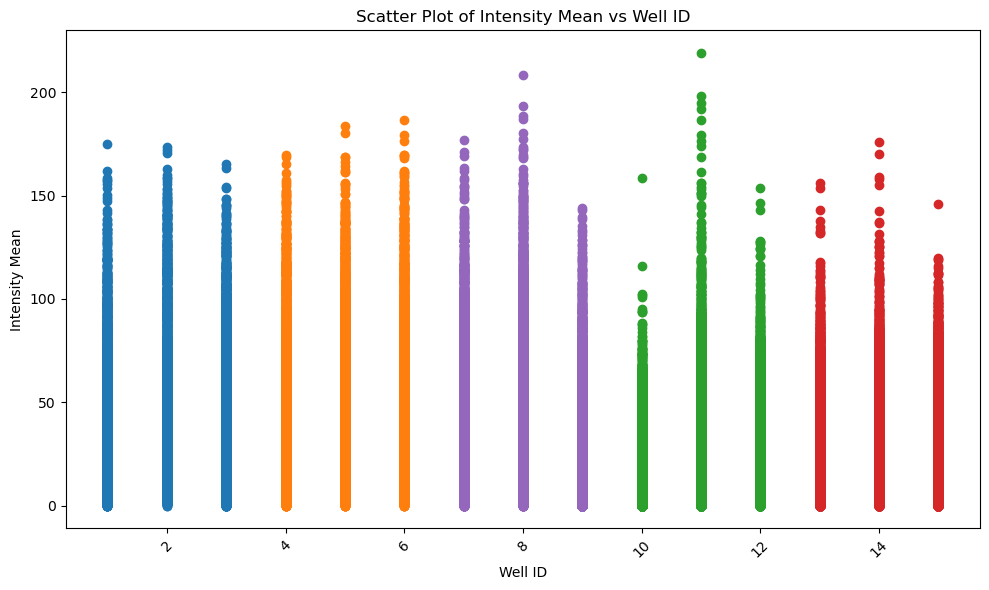

In [33]:
# Plotting
plt.figure(figsize=(10, 6))
for treatment, group in merged_df.groupby('treatment'):
    plt.scatter(group['well_id'], group['intensity_mean'], label=well_id)

plt.xlabel('Well ID')
plt.ylabel('Intensity Mean')
plt.title('Scatter Plot of Intensity Mean vs Well ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

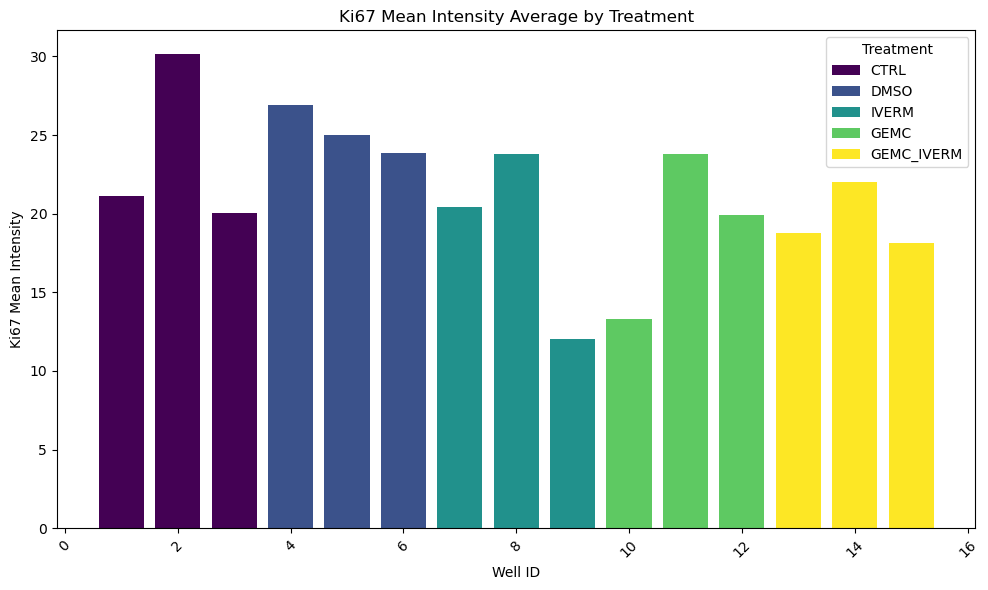

In [36]:
# Calculate the mean value of intensity mean for each well_id
mean_intensity = merged_df.groupby('well_id')['intensity_mean'].mean().reset_index()

# Merge back with sample_ids_df to get the treatment for each well_id
mean_intensity_with_treatment = pd.merge(mean_intensity, sample_ids_df, on='well_id', how='left')

# Plotting
plt.figure(figsize=(10, 6))

# Get unique treatments for color differentiation
treatments = mean_intensity_with_treatment['treatment'].unique()

# Assign a color to each treatment
colors = plt.cm.viridis(np.linspace(0, 1, len(treatments)))
treatment_color_map = dict(zip(treatments, colors))

for treatment, color in treatment_color_map.items():
    # Filter rows for the current treatment
    treatment_data = mean_intensity_with_treatment[mean_intensity_with_treatment['treatment'] == treatment]
    
    # Plot each treatment group with its associated color
    plt.bar(treatment_data['well_id'], treatment_data['intensity_mean'], color=color, label=treatment)

plt.xlabel('Well ID')
plt.ylabel('Ki67 Mean Intensity')
plt.title('Ki67 Mean Intensity Average by Treatment')
plt.xticks(rotation=45)
plt.legend(title='Treatment')
plt.tight_layout()
plt.show()
